<a href="https://colab.research.google.com/github/bhuvanesh2003/Translator-English-to-Telugu-/blob/main/Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Imports

In [ ]:
import numpy as np
import torch
import math
from torch import nn
import torch.nn.functional as F

In [ ]:
!pip install -q torchinfo
from torchinfo import summary

In [ ]:
def get_device():
    return torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Getting Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
english_file = '/content/drive/MyDrive/English to Telugu Translator/train.en'
telugu_file = '/content/drive/MyDrive/English to Telugu Translator/train.te'

In [ ]:
# English Vocabulary

START_TOKEN = '<START>'
PADDING_TOKEN = '<PADDING>'
END_TOKEN = '<END>'
english_vocabulary = [START_TOKEN, ' ', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/',
                        '0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
                        ':', '<', '=', '>', '?', '@',
                        '[', '\\', ']', '^', '_', '`',
                        'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l',
                        'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x',
                        'y', 'z',
                        '{', '|', '}', '~', PADDING_TOKEN, END_TOKEN]


In [ ]:
# Telugu Vocabulary

START_TOKEN = '<START>'
PADDING_TOKEN = '<PADDING>'
END_TOKEN = '<END>'

telugu_vocabulary = [START_TOKEN, ' ', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/',
                     '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', '<', '=', '>', '?', 'ˌ',
                     'ఁ', 'ఆ', 'ఇ', 'ా', 'ి', 'ీ', 'ు', 'ూ',
                     'అ', 'ఆ', 'ఇ', 'ఈ', 'ఉ', 'ఊ', 'ఋ', 'ౠ', 'ఌ', 'ఎ', 'ఏ', 'ఐ', 'ఒ', 'ఓ', 'ఔ',
                     'క', 'ఖ', 'గ', 'ఘ', 'ఙ',
                     'చ', 'ఛ', 'జ', 'ఝ', 'ఞ',
                     'ట', 'ఠ', 'డ', 'ఢ', 'ణ',
                     'త', 'థ', 'ద', 'ధ', 'న',
                     'ప', 'ఫ', 'బ', 'భ', 'మ',
                     'య', 'ర', 'ల', 'వ', 'శ', 'ష', 'స', 'హ', 'క్ష', 'ళ', 'ఱ',
                     '఼', 'ఽ', 'ా', 'ి', 'ీ', 'ు', 'ూ', 'ృ', 'ౄ', 'ె', 'ే', 'ై', 'ొ', 'ో', 'ౌ', '్', 'ౕ', 'ౖ', 'ౣ', 'ం', 'ః',
                     '౦', '౧', '౨', '౩', '౪', '౫', '౬', '౭', '౮', '౯', 'H',PADDING_TOKEN, END_TOKEN]

# Ensure unique elements while maintaining the original order
telugu_vocabulary = sorted(set(telugu_vocabulary), key=telugu_vocabulary.index)

In [ ]:
len(telugu_vocabulary)

119

In [ ]:
# Creating 'INDEX Mappings'

index_to_telugu = {k:v for k,v in enumerate(telugu_vocabulary)}
telugu_to_index = {v:k for k,v in enumerate(telugu_vocabulary)}
index_to_english = {k:v for k,v in enumerate(english_vocabulary)}
english_to_index = {v:k for k,v in enumerate(english_vocabulary)}

In [ ]:
# len(telugu_to_index)
len(index_to_telugu)

119

In [ ]:
# Semanantar Dataset train Files

with open(english_file, 'r') as file:
    english_sentences = file.readlines()
with open(telugu_file, 'r') as file:
    telugu_sentences = file.readlines()

In [ ]:
# Limit Number of sentences
TOTAL_SENTENCES = 1000000                                      # 1 Million
english_sentences = english_sentences[:TOTAL_SENTENCES]
telugu_sentences = telugu_sentences[:TOTAL_SENTENCES]
english_sentences = [sentence.rstrip('\n').lower() for sentence in english_sentences]
telugu_sentences = [sentence.rstrip('\n') for sentence in telugu_sentences]

In [ ]:
english_sentences[:10]

['rise again.',
 'how do we glorify jehovahs undeserved kindness?',
 'india also continues to push back economically.',
 'i remember my childhood days.',
 'all transactions are made online.',
 'i love night shoots in my city.',
 'three members of a family were killed in the incident.',
 'the film is directed by v v vinayak.',
 'the hyderabad weather office forecast more rains.',
 'we are family!']

In [ ]:
telugu_sentences[:10]

['మళ్లీ ఉదయిస్తాడు.',
 'యెహోవా కృపను మనమెలా మహిమపరచవచ్చు?',
 'ఆర్థికంగా కూడా భారత్\u200c వే గంగా పయనిస్తున్నది.',
 '‘విద్యార్థులను చూస్తుంటే నాకు చిన్నప్పటి రోజులు గుర్తుకొస్తున్నాయి.',
 'ఆర్థిక లావాదేవీలన్నీ ఆన్\u200cలైన్\u200cలోనే',
 'పద్మినీ స్త్రీ రాత్రి వేళల్లో రతికి ఇష్టపడదు.',
 'ఓకే కుటుంబానికి చెందిన ముగ్గురు మృతిచెందటంతో ఈ సంఘటన కలవరపర్చింది.',
 'ఆ సినిమాకు వి. వి. వినాయక్\u200c దర్శకత్వం వహించనున్నారు.',
 'హైదరాబాద్\u200cకు మరో భారీ వర్షం సూచనలున్నాయని వాతావరణ శాఖ హెచ్చరించింది.',
 'మనం అంటున్న మమ్ముట్టి ఫ్యామిలీ !']

In [ ]:
max_sequence_length = 200                                   # Limiting this due to Computational Resources

def is_valid_tokens(sentence, vocab):                       # To check tokens are Valid or not
    for token in list(set(sentence)):
        if token not in vocab:
            return False
    return True

def is_valid_length(sentence, max_sequence_length):         # Is length Valid or not
    return len(list(sentence)) < (max_sequence_length - 1)

valid_sentence_indicies = []
for index in range(len(telugu_sentences)):
    telugu_sentence, english_sentence = telugu_sentences[index], english_sentences[index]
    if is_valid_length(telugu_sentence, max_sequence_length) \
      and is_valid_length(english_sentence, max_sequence_length) \
      and is_valid_tokens(telugu_sentence, telugu_vocabulary):
        valid_sentence_indicies.append(index)

print(f"Number of sentences: {len(telugu_sentences)}")
print(f"Number of valid sentences: {len(valid_sentence_indicies)}")

Number of sentences: 1000000
Number of valid sentences: 756527


In [ ]:
# Taking therequired Sentences
telugu_sentences = [telugu_sentences[i] for i in valid_sentence_indicies]
english_sentences = [english_sentences[i] for i in valid_sentence_indicies]

In [ ]:
english_sentences[:2]

['rise again.', 'how do we glorify jehovahs undeserved kindness?']

In [ ]:
telugu_sentences[:2]

['మళ్లీ ఉదయిస్తాడు.', 'యెహోవా కృపను మనమెలా మహిమపరచవచ్చు?']

In [ ]:
val_english_sentences = english_sentences[-200:]
val_telugu_sentences = telugu_sentences[-200:]

## Making into Data Loaders

In [ ]:
from torch.utils.data import Dataset, DataLoader

class TextDataset(Dataset):

    def __init__(self, english_sentences, telugu_sentences):
        self.english_sentences = english_sentences
        self.telugu_sentences = telugu_sentences

    def __len__(self):
        return len(self.english_sentences)

    def __getitem__(self, idx):
        return self.english_sentences[idx], self.telugu_sentences[idx]

In [ ]:
dataset = TextDataset(english_sentences, telugu_sentences)

In [ ]:
len(dataset)

756527

In [ ]:
dataset[1]

('how do we glorify jehovahs undeserved kindness?',
 'యెహోవా కృపను మనమెలా మహిమపరచవచ్చు?')

In [ ]:
batch_size = 400
train_loader = DataLoader(dataset, batch_size)
iterator = iter(train_loader)

In [ ]:
for batch_num, batch in enumerate(iterator):
    print(batch)
    batch1 = batch
    if batch_num > 1:
        break

[('rise again.', 'how do we glorify jehovahs undeserved kindness?', 'i love night shoots in my city.', 'three members of a family were killed in the incident.', 'we are family!', 'in this context, the rs.', 'what is the phrase?', 'in monaco-ville, street signs are printed in both french and mongasque.', 'the same has been confirmed in a report carried by bbc.', "i said, 'who are you?'", 'in this state they can easily survive one year or longer.', 'the complete details of his death are yet to be known.', 'if you go...', 'what is this, child?', 'we have seen many such cases.', 'the redmi 4 is available in three versions.', 'however, there has been no official statement on this yet.', 'annual international yoga day is a modern celebration of the ancient indian discipline.', 'the skirting at the side and the rear bumper is decked in faux carbon fibre', 'finally, a little blue engine arrives.', 'the rooms are spacious and well furnished.', 'the teaser of the song was released.', 'the proble

In [ ]:
iterator

In [ ]:
val_dataset = TextDataset(val_english_sentences, val_telugu_sentences)

In [ ]:
val_batchsize = 40
val_loader = DataLoader(val_dataset,val_batchsize)
val_iterator = iter(val_loader)

## Tokenize
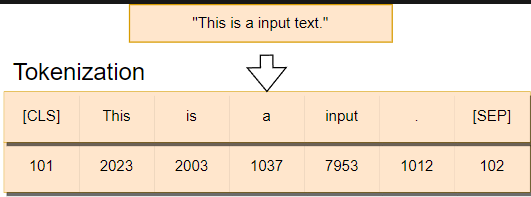

In [ ]:
d_model = 512
language_to_index = telugu_to_index

In [ ]:
def tokenize(sentence, language_to_index, start_token=True, end_token=True):
    sentence_word_indicies = [language_to_index[token] for token in list(sentence)]
    if start_token:
        sentence_word_indicies.insert(0, language_to_index[START_TOKEN])
    if end_token:
        sentence_word_indicies.append(language_to_index[END_TOKEN])
    for _ in range(len(sentence_word_indicies), max_sequence_length):
        sentence_word_indicies.append(language_to_index[PADDING_TOKEN])
    return torch.tensor(sentence_word_indicies)

In [ ]:
telugu_sentences[0]

'మళ్లీ ఉదయిస్తాడు.'

In [ ]:
tokenized_telugu_sentence = tokenize(telugu_sentences[0],language_to_index,start_token=True, end_token=True)
print('Tokenized telugu sentence:\n',tokenized_telugu_sentence)

Tokenized telugu sentence:
 tensor([  0,  78,  88, 100,  81,  38,   1,  43,  71,  79,  37,  85, 100,  69,
         36,  66,  39,  15, 118, 117, 117, 117, 117, 117, 117, 117, 117, 117,
        117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117,
        117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117,
        117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117,
        117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117,
        117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117,
        117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117,
        117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117,
        117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117,
        117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117,
        117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117,
        117, 117, 117, 117, 117, 117

# Positional Encoding

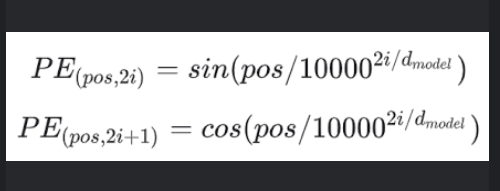



In [ ]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_sequence_length):
        super().__init__()
        self.max_sequence_length = max_sequence_length
        self.d_model = d_model

    def forward(self):
        even_i = torch.arange(0, self.d_model, 2).float()
        denominator = torch.pow(10000, even_i/self.d_model)
        position = (torch.arange(self.max_sequence_length)
                          .reshape(self.max_sequence_length, 1))
        even_PE = torch.sin(position / denominator)
        odd_PE = torch.cos(position / denominator)
        stacked = torch.stack([even_PE, odd_PE], dim=2)
        PE = torch.flatten(stacked, start_dim=1, end_dim=2)
        return PE

In [ ]:
# Example for PositionalEncoding

position_encoder = PositionalEncoding(d_model, max_sequence_length)
embedding = nn.Embedding(len(language_to_index), 512)
telugu_embedding = embedding(tokenized_telugu_sentence)                   # Converted Tokens into Embedding
pos = position_encoder()
positional_encoded_telugu_sentence = telugu_embedding + pos
# positional_encoded_telugu_sentence.size()

In [ ]:
print('Positional Encoding Matrix Size: ', positional_encoded_telugu_sentence.size())
print(positional_encoded_telugu_sentence)

Positional Encoding Matrix Size:  torch.Size([200, 512])
tensor([[ 1.5406,  0.7043, -0.1402,  ...,  1.9942,  1.1459,  1.2439],
        [ 1.5071,  1.1773,  1.7084,  ...,  2.0092, -1.2940,  2.0594],
        [ 2.1023, -0.7119,  2.3906,  ...,  1.3759, -2.6780,  3.4930],
        ...,
        [ 0.3067,  0.0166,  0.8943,  ...,  1.1285,  0.7572,  1.9111],
        [-0.5687, -0.3747,  0.4872,  ...,  1.1285,  0.7573,  1.9111],
        [-1.3709,  0.1505, -0.4299,  ...,  1.1285,  0.7574,  1.9111]],
       grad_fn=<AddBackward0>)


# Batch Encoding

1.   Loading the data as the batches and Tokenize them all
2.   All Tokenized sentences are converted into Embeddings
3.   Positional Encoding is done to all Embeddings



In [ ]:
class SentenceEmbedding(nn.Module):
    "For a given sentence, create an embedding"
    def __init__(self, max_sequence_length, d_model, language_to_index, START_TOKEN, END_TOKEN, PADDING_TOKEN):
        super().__init__()
        self.vocab_size = len(language_to_index)                                                      # Length of the Vocabulary
        self.max_sequence_length = max_sequence_length                                                # 200
        self.embedding = nn.Embedding(self.vocab_size, d_model)
        self.language_to_index = language_to_index
        self.position_encoder = PositionalEncoding(d_model, max_sequence_length)                      # positional Encoding
        self.dropout = nn.Dropout(p=0.1)                                                              # Dropout layer
        self.START_TOKEN = START_TOKEN
        self.END_TOKEN = END_TOKEN
        self.PADDING_TOKEN = PADDING_TOKEN

    def batch_tokenize(self, batch, start_token, end_token):

        def tokenize(sentence, start_token, end_token):
            sentence_word_indicies = [self.language_to_index[token] for token in list(sentence)]
            if start_token:                                                                            # Add Start token if needed
                sentence_word_indicies.insert(0, self.language_to_index[self.START_TOKEN])
            if end_token:                                                                              # Add End token if needed
                sentence_word_indicies.append(self.language_to_index[self.END_TOKEN])
            for _ in range(len(sentence_word_indicies), self.max_sequence_length):
                sentence_word_indicies.append(self.language_to_index[self.PADDING_TOKEN])
            return torch.tensor(sentence_word_indicies)

        tokenized = []
        for sentence_num in range(len(batch)):
           tokenized.append( tokenize(batch[sentence_num], start_token, end_token) )
        tokenized = torch.stack(tokenized)
        return tokenized.to(get_device())

    def forward(self, x, start_token, end_token): # sentence
        x = self.batch_tokenize(x, start_token, end_token)                   # Tokenize them
        x = self.embedding(x)                                                # Make Embeddings
        pos = self.position_encoder().to(get_device())
        x = self.dropout(x + pos)                                            # Add Positional Encoding
        return x

In [ ]:
# Example

# batch1[1]

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Multi Head Attention
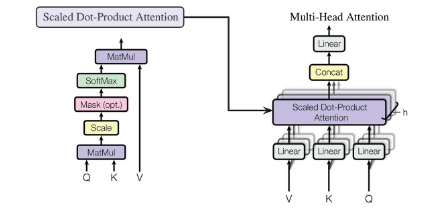

In [ ]:
def softmax(x):
  return (np.exp(x).T / np.sum(np.exp(x), axis=-1)).T

def self_attention(q, k, v, mask=None):
  d_k = q.shape[-1]
  scaled = np.matmul(q, k.T) / math.sqrt(d_k)
  if mask is not None:
    scaled = scaled + mask
  attention = softmax(scaled)
  out = np.matmul(attention, v)
  return out, attention

In [ ]:
# Example
L, d_k, d_v = 4, 8, 8
q = np.random.randn(L, d_k)
k = np.random.randn(L, d_k)
v = np.random.randn(L, d_v)
values, attention = self_attention(q, k, v, mask=None)
attention

array([[0.08247584, 0.01919088, 0.81509935, 0.08323392],
       [0.09755933, 0.27285482, 0.24957332, 0.38001253],
       [0.24114411, 0.37293063, 0.22883696, 0.15708829],
       [0.0988025 , 0.22443104, 0.32837433, 0.34839213]])

In [ ]:
def self_attention(q, k, v, mask=None):
    d_k = q.size()[-1]
    scaled = torch.matmul(q, k.transpose(-1, -2)) / math.sqrt(d_k)
    if mask is not None:
        scaled = scaled.permute(1, 0, 2, 3) + mask
        scaled = scaled.permute(1, 0, 2, 3)
    attention = F.softmax(scaled, dim=-1)
    values = torch.matmul(attention, v)
    return values, attention

class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super().__init__()
        self.d_model = d_model
        self.num_heads = num_heads
        self.head_dim = d_model // num_heads
        self.qkv_layer = nn.Linear(d_model , 3 * d_model)
        self.linear_layer = nn.Linear(d_model, d_model)

    def forward(self, x, mask):
        batch_size, sequence_length, d_model = x.size()
        qkv = self.qkv_layer(x)
        qkv = qkv.reshape(batch_size, sequence_length, self.num_heads, 3 * self.head_dim)
        qkv = qkv.permute(0, 2, 1, 3)
        q, k, v = qkv.chunk(3, dim=-1)
        values, attention = self_attention(q, k, v, mask)
        values = values.permute(0, 2, 1, 3).reshape(batch_size, sequence_length, self.num_heads * self.head_dim)
        out = self.linear_layer(values)
        return out

# Layer Normalization

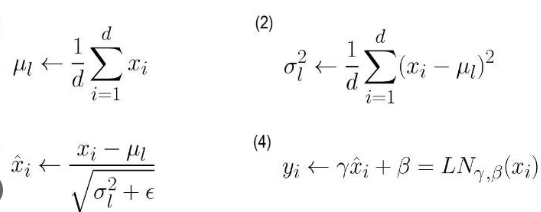

In [ ]:
class LayerNormalization(nn.Module):
    def __init__(self, parameters_shape, eps=1e-5):
        super().__init__()
        self.parameters_shape=parameters_shape
        self.eps=eps
        self.gamma = nn.Parameter(torch.ones(parameters_shape))           # Gamma Parameter
        self.beta =  nn.Parameter(torch.zeros(parameters_shape))          # Beta Parameter

    def forward(self, inputs):
        dims = [-(i + 1) for i in range(len(self.parameters_shape))]      # Last Dimension
        mean = inputs.mean(dim=dims, keepdim=True)                        # Calculation Mean
        var = ((inputs - mean) ** 2).mean(dim=dims, keepdim=True)
        std = (var + self.eps).sqrt()                                     # Calculation Standard Deviation
        y = (inputs - mean) / std                                         # Normalize Values
        out = self.gamma * y + self.beta
        return out

# Feed Forward Network

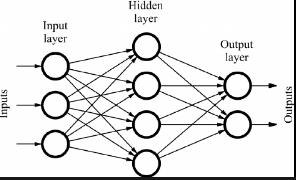

In [ ]:
class FeedForwardNetwork(nn.Module):
    def __init__(self, d_model, hidden, drop_prob=0.1):                   # Dimension of the Model, no of hidden layers and dropout probability
        super(FeedForwardNetwork, self).__init__()
        self.linear1 = nn.Linear(d_model, hidden)
        self.linear2 = nn.Linear(hidden, d_model)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=drop_prob)

    def forward(self, x):
        x = self.linear1(x)                                              # Linear Layer 1
        x = self.relu(x)                                                 # Non-Linear Activation Function ReLU
        x = self.dropout(x)                                              # Dropout Layer
        x = self.linear2(x)                                              # Linear Layer 2
        return x

# Encoder

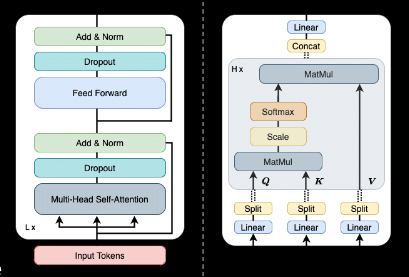

In [ ]:
class EncoderLayer(nn.Module):
    def __init__(self, d_model, ffn_hidden, num_heads, drop_prob):                            # Dimenion, hiddden Layers, no of Attn heads, drop probability
        super(EncoderLayer, self).__init__()
        self.attention = MultiHeadAttention(d_model=d_model, num_heads=num_heads)             # Multihead Attention
        self.norm1 = LayerNormalization(parameters_shape=[d_model])                           # Normalize
        self.dropout1 = nn.Dropout(p=drop_prob)                                               # Dropout Layer
        self.ffn = FeedForwardNetwork(d_model=d_model, hidden=ffn_hidden, drop_prob=drop_prob) # Feed Forward Network
        self.norm2 = LayerNormalization(parameters_shape=[d_model])                            # Normalize
        self.dropout2 = nn.Dropout(p=drop_prob)                                               # Dropout Layer

    def forward(self, x, self_attention_mask):
        residual_x = x.clone()
        x = self.attention(x, mask=self_attention_mask)
        x = self.dropout1(x)
        x = self.norm1(x + residual_x)                                                        # Adding Residuals and normailze
        residual_x = x.clone()
        x = self.ffn(x)
        x = self.dropout2(x)
        x = self.norm2(x + residual_x)                                                        # Adding Residuals and normailze
        return x

In [ ]:
class SequentialEncoder(nn.Sequential):
    def forward(self, *inputs):
        x, self_attention_mask  = inputs
        for module in self._modules.values():
            x = module(x, self_attention_mask)
        return x

## Putting All together from batch embedding to Encoder

In [ ]:
class Encoder(nn.Module):
    def __init__(self,
                 d_model,
                 ffn_hidden,
                 num_heads,
                 drop_prob,
                 num_layers,
                 max_sequence_length,
                 language_to_index,
                 START_TOKEN,
                 END_TOKEN,
                 PADDING_TOKEN):
        super().__init__()
        self.sentence_embedding = SentenceEmbedding(max_sequence_length, d_model, language_to_index, START_TOKEN, END_TOKEN, PADDING_TOKEN)
        self.layers = SequentialEncoder(*[EncoderLayer(d_model, ffn_hidden, num_heads, drop_prob)
                                      for _ in range(num_layers)])

    def forward(self, x, self_attention_mask, start_token, end_token):
        x = self.sentence_embedding(x, start_token, end_token)
        x = self.layers(x, self_attention_mask)
        return x

In [ ]:
d_model = 512
ffn_hidden = 2048
num_heads = 8
drop_prob = 0.1
num_layers = 8
max_sequence_length = 200

# Multihead Cross Attention

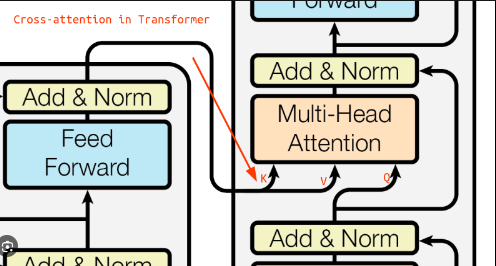

In [ ]:
class MultiHeadCrossAttention(nn.Module):
    def __init__(self, d_model, num_heads):                    # Dimension of the Model, No of Attn heads
        super().__init__()
        self.d_model = d_model
        self.num_heads = num_heads
        self.head_dim = d_model // num_heads
        self.kv_layer = nn.Linear(d_model , 2 * d_model)       # K,V layer
        self.q_layer = nn.Linear(d_model , d_model)
        self.linear_layer = nn.Linear(d_model, d_model)

    def forward(self, x, y, mask):
        batch_size, sequence_length, d_model = x.size()
        kv = self.kv_layer(x)
        q = self.q_layer(y)
        kv = kv.reshape(batch_size, sequence_length, self.num_heads, 2 * self.head_dim)
        q = q.reshape(batch_size, sequence_length, self.num_heads, self.head_dim)
        kv = kv.permute(0, 2, 1, 3)
        q = q.permute(0, 2, 1, 3)
        k, v = kv.chunk(2, dim=-1)
        values, attention = self_attention(q, k, v, mask)
        values = values.permute(0, 2, 1, 3).reshape(batch_size, sequence_length, d_model)
        out = self.linear_layer(values)
        return out


# Decoder

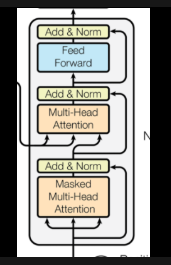

In [ ]:
class DecoderLayer(nn.Module):
    def __init__(self, d_model, ffn_hidden, num_heads, drop_prob):                       # Dimension of the model, no of Attn heads, Drop probability
        super(DecoderLayer, self).__init__()
        self.self_attention = MultiHeadAttention(d_model=d_model, num_heads=num_heads)    # Multihead Attention
        self.layer_norm1 = LayerNormalization(parameters_shape=[d_model])                 # Layer Normalize 1
        self.dropout1 = nn.Dropout(p=drop_prob)                                           # Drop Layer 1

        self.encoder_decoder_attention = MultiHeadCrossAttention(d_model=d_model, num_heads=num_heads)  # Cross Attention
        self.layer_norm2 = LayerNormalization(parameters_shape=[d_model])                 # Layer Normalize 2
        self.dropout2 = nn.Dropout(p=drop_prob)                                           # Drop Layer 2

        self.ffn = FeedForwardNetwork(d_model=d_model, hidden=ffn_hidden, drop_prob=drop_prob) # Feed Forward Network
        self.layer_norm3 = LayerNormalization(parameters_shape=[d_model])                 # Layer Normalize 3
        self.dropout3 = nn.Dropout(p=drop_prob)                                           # Drop Layer 3

    def forward(self, x, y, self_attention_mask, cross_attention_mask):
        y_residual = y.clone()
        y = self.self_attention(y, mask=self_attention_mask)
        y = self.dropout1(y)
        y = self.layer_norm1(y + y_residual)                                                      # Add Residuals

        y_residual = y.clone()
        y = self.encoder_decoder_attention(x, y, mask=cross_attention_mask)               # Cross Attention
        y = self.dropout2(y)
        y = self.layer_norm2(y + y_residual)

        y_residual = y.clone()
        y = self.ffn(y)
        y = self.dropout3(y)
        y = self.layer_norm3(y + y_residual)
        return y


In [ ]:
class SequentialDecoder(nn.Sequential):
    def forward(self, *inputs):
        x, y, self_attention_mask, cross_attention_mask = inputs
        for module in self._modules.values():
            y = module(x, y, self_attention_mask, cross_attention_mask)
        return y

## Putting all together for Decoder

In [ ]:
class Decoder(nn.Module):
    def __init__(self,
                 d_model,
                 ffn_hidden,
                 num_heads,
                 drop_prob,
                 num_layers,
                 max_sequence_length,
                 language_to_index,
                 START_TOKEN,
                 END_TOKEN,
                 PADDING_TOKEN):
        super().__init__()
        self.sentence_embedding = SentenceEmbedding(max_sequence_length, d_model, language_to_index, START_TOKEN, END_TOKEN, PADDING_TOKEN)  # Sentence Embedding
        self.layers = SequentialDecoder(*[DecoderLayer(d_model, ffn_hidden, num_heads, drop_prob) for _ in range(num_layers)])               # Decoder Layer

    def forward(self, x, y, self_attention_mask, cross_attention_mask, start_token, end_token):
        y = self.sentence_embedding(y, start_token, end_token)
        y = self.layers(x, y, self_attention_mask, cross_attention_mask)
        return y

# Transformer

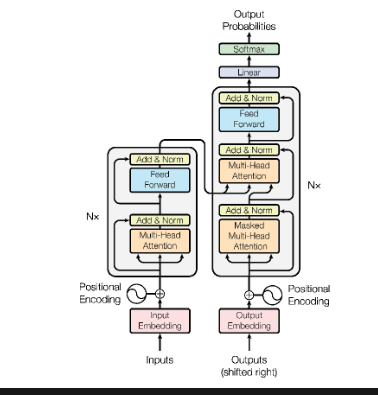

In [ ]:
class Transformer(nn.Module):
    def __init__(self,
                d_model,
                ffn_hidden,
                num_heads,
                drop_prob,
                num_layers,
                max_sequence_length,
                tl_vocab_size,
                english_to_index,
                telugu_to_index,
                START_TOKEN,
                END_TOKEN,
                PADDING_TOKEN
                ):
        super().__init__()
        self.encoder = Encoder(d_model, ffn_hidden, num_heads, drop_prob, num_layers, max_sequence_length, english_to_index, START_TOKEN, END_TOKEN, PADDING_TOKEN)
        self.decoder = Decoder(d_model, ffn_hidden, num_heads, drop_prob, num_layers, max_sequence_length, telugu_to_index, START_TOKEN, END_TOKEN, PADDING_TOKEN)
        self.linear = nn.Linear(d_model, tl_vocab_size)               # Predict the characters in the Vocabulary
        self.device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

    def forward(self,
                x,
                y,
                encoder_self_attention_mask=None,
                decoder_self_attention_mask=None,
                decoder_cross_attention_mask=None,

                enc_start_token=False,
                enc_end_token=False,
                dec_start_token=False,
                dec_end_token=False):
        x = self.encoder(x, encoder_self_attention_mask, start_token=enc_start_token, end_token=enc_end_token)
        out = self.decoder(x, y, decoder_self_attention_mask, decoder_cross_attention_mask, start_token=dec_start_token, end_token=dec_end_token)
        out = self.linear(out)
        return out

In [ ]:
# Initialisation  of Transformer

d_model = 512                                      # Dimension of the model
batch_size = 400
ffn_hidden = 2048                                  # No of Hidden Layers
num_heads = 8                                      # No of Attn heads
drop_prob = 0.1                                    # Drop Probability
num_layers = 1                                     # no of Encoder and Decoder Layers
max_sequence_length = 200
tl_vocab_size = len(telugu_vocabulary)
transformer = Transformer(d_model,
                          ffn_hidden,
                          num_heads,
                          drop_prob,
                          num_layers,
                          max_sequence_length,
                          tl_vocab_size,
                          english_to_index,
                          telugu_to_index,
                          START_TOKEN,
                          END_TOKEN,
                          PADDING_TOKEN)

In [ ]:
transformer.parameters()

<generator object Module.parameters at 0x793aab04b6f0>

In [ ]:
transformer

Transformer(
  (encoder): Encoder(
    (sentence_embedding): SentenceEmbedding(
      (embedding): Embedding(71, 512)
      (position_encoder): PositionalEncoding()
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (layers): SequentialEncoder(
      (0): EncoderLayer(
        (attention): MultiHeadAttention(
          (qkv_layer): Linear(in_features=512, out_features=1536, bias=True)
          (linear_layer): Linear(in_features=512, out_features=512, bias=True)
        )
        (norm1): LayerNormalization()
        (dropout1): Dropout(p=0.1, inplace=False)
        (ffn): FeedForwardNetwork(
          (linear1): Linear(in_features=512, out_features=2048, bias=True)
          (linear2): Linear(in_features=2048, out_features=512, bias=True)
          (relu): ReLU()
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (norm2): LayerNormalization()
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (decoder): Decoder(
    (sentence_embedding): Sent

# Tranining

In [ ]:
from torch import nn

criterian = nn.CrossEntropyLoss(ignore_index=telugu_to_index[PADDING_TOKEN],
                                reduction='none')

for params in transformer.parameters():
    if params.dim() > 1:
        nn.init.xavier_uniform_(params)

optim = torch.optim.Adam(transformer.parameters(), lr=1e-4)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

## Creating Masks

In [ ]:
NEG_INFTY = -1e9

def create_masks(eng_batch, tl_batch):
    num_sentences = len(eng_batch)
    look_ahead_mask = torch.full([max_sequence_length, max_sequence_length] , True)
    look_ahead_mask = torch.triu(look_ahead_mask, diagonal=1)
    encoder_padding_mask = torch.full([num_sentences, max_sequence_length, max_sequence_length] , False)
    decoder_padding_mask_self_attention = torch.full([num_sentences, max_sequence_length, max_sequence_length] , False)
    decoder_padding_mask_cross_attention = torch.full([num_sentences, max_sequence_length, max_sequence_length] , False)

    for idx in range(num_sentences):
      eng_sentence_length, tl_sentence_length = len(eng_batch[idx]), len(tl_batch[idx])
      eng_chars_to_padding_mask = np.arange(eng_sentence_length + 1, max_sequence_length)
      tl_chars_to_padding_mask = np.arange(tl_sentence_length + 1, max_sequence_length)
      encoder_padding_mask[idx, :, eng_chars_to_padding_mask] = True
      encoder_padding_mask[idx, eng_chars_to_padding_mask, :] = True
      decoder_padding_mask_self_attention[idx, :, tl_chars_to_padding_mask] = True
      decoder_padding_mask_self_attention[idx, tl_chars_to_padding_mask, :] = True
      decoder_padding_mask_cross_attention[idx, :, eng_chars_to_padding_mask] = True
      decoder_padding_mask_cross_attention[idx, tl_chars_to_padding_mask, :] = True

    encoder_self_attention_mask = torch.where(encoder_padding_mask, NEG_INFTY, 0)
    decoder_self_attention_mask =  torch.where(look_ahead_mask + decoder_padding_mask_self_attention, NEG_INFTY, 0)
    decoder_cross_attention_mask = torch.where(decoder_padding_mask_cross_attention, NEG_INFTY, 0)
    return encoder_self_attention_mask, decoder_self_attention_mask, decoder_cross_attention_mask

In [ ]:
# Create lists to store reference and hypothesis translations
references = []
hypotheses = []

In [ ]:
!pip install nltk

In [ ]:
import nltk
from nltk.translate.bleu_score import sentence_bleu
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
# Training Part

transformer.train()
transformer.to(device)                            # Sending the model to Cuda
total_loss = 0
num_epochs = 5

for epoch in range(num_epochs):
    print(f"Epoch {epoch}")
    iterator = iter(train_loader)
    for batch_num, batch in enumerate(iterator):
        transformer.train()
        eng_batch, tl_batch = batch
        encoder_self_attention_mask, decoder_self_attention_mask, decoder_cross_attention_mask = create_masks(eng_batch, tl_batch)
        optim.zero_grad()
        tl_predictions = transformer(eng_batch,
                                     tl_batch,
                                     encoder_self_attention_mask.to(device),
                                     decoder_self_attention_mask.to(device),
                                     decoder_cross_attention_mask.to(device),
                                     enc_start_token=False,
                                     enc_end_token=False,
                                     dec_start_token=True,
                                     dec_end_token=True)                              # Forward Method
        labels = transformer.decoder.sentence_embedding.batch_tokenize(tl_batch, start_token=False, end_token=True)
        loss = criterian(
            tl_predictions.view(-1, tl_vocab_size).to(device),
            labels.view(-1).to(device)
        ).to(device)
        valid_indicies = torch.where(labels.view(-1) == telugu_to_index[PADDING_TOKEN], False, True)
        loss = loss.sum() / valid_indicies.sum()
        loss.backward()
        optim.step()
        if batch_num % 500 == 0:
            print(f"Iteration {batch_num} : {loss.item()}")
            print(f"English: {eng_batch[0]}")
            print(f"telugu Translation: {tl_batch[0]}")
            tl_sentence_predicted = torch.argmax(tl_predictions[0], axis=1)
            predicted_sentence = ""
            for idx in tl_sentence_predicted:
              if idx == telugu_to_index[END_TOKEN]:
                break
              predicted_sentence += index_to_telugu[idx.item()]
            print(f"telugu Prediction: {predicted_sentence}")


            transformer.eval()
            tl_sentence = ("",)
            eng_sentence = ("hi, how are you",)
            for word_counter in range(max_sequence_length):
                encoder_self_attention_mask, decoder_self_attention_mask, decoder_cross_attention_mask= create_masks(eng_sentence, tl_sentence)
                predictions = transformer(eng_sentence,
                                          tl_sentence,
                                          encoder_self_attention_mask.to(device),
                                          decoder_self_attention_mask.to(device),
                                          decoder_cross_attention_mask.to(device),
                                          enc_start_token=False,
                                          enc_end_token=False,
                                          dec_start_token=True,
                                          dec_end_token=False)
                next_token_prob_distribution = predictions[0][word_counter] # not actual probs
                next_token_index = torch.argmax(next_token_prob_distribution).item()
                next_token = index_to_telugu[next_token_index]
                tl_sentence = (tl_sentence[0] + next_token, )
                if next_token == END_TOKEN:
                  break

            print(f"Evaluation translation (hi, how are you) : {tl_sentence}")
            print("-------------------------------------------")

Epoch 0
Iteration 0 : 5.79829216003418
English: rise again.
telugu Translation: మళ్లీ ఉదయిస్తాడు.
telugu Prediction: ైైైభ====ైై=ైై======1==ల=ీీఱ=1ద====ై=11==బ==ఖ్ఱైమైమమ=మడలైై=్=ఖీల=ు===ైీీీ====11బ=ఢఢైీై=ైైైైైైైైైైైైభభచ1్ైైైలైై్=్1ైఱఱఞఱ=లైైైైఢఛ1ైైౖీఏౖౖౖైైైలఏై్ీౖై్ౖ1ు=ై===్===:=ుఏఞఓలఓలైైైల=లలలైైై=గలైైైైి్ైల్్గ్ఢ్44్్=
Evaluation translation (hi, how are you) : ('ఓలలలలలిలలలలలలేలేఖేేేలలలలలలలలలలలలిిిిిలలలలలలలలలలమమమమడడలలంంంంంిిలల    మమఓఓ ఓఉఉ1ౣ మమమలలలల  లలల్లలలల్్్్్్్్్్లలలల్్ిిిలలలలలలలలలలిిిిిిిఆలలలలలలలలలలిిిిిిులలలగగుుుుుిిిిలలలలలలలలలలలలలిలలలలిిిిి్్్లిిిిిిిిి',)
-------------------------------------------
Iteration 500 : 2.6678433418273926
English: i shouted out.
telugu Translation: నేను గట్టిగా అరిచాను.
telugu Prediction: అా ి కా్న్ంి కంింేయా.
Evaluation translation (hi, how are you) : ('అంది క్ర్ర్ని క్ర్రు.<END>',)
-------------------------------------------
Iteration 1000 : 2.483945608139038
English: dont worry
telugu Translation: దిగులు చెందొద్దు
telugu Prediction: కీన్ ు వేలద్ంిని


# Translate and BLEU Scores

In [ ]:
def translate(eng_sentence):
  transformer.eval()
  tl_sentence = ("",)
  eng_sentence = (eng_sentence.lower(),)
  for word_counter in range(max_sequence_length):
    encoder_self_attention_mask, decoder_self_attention_mask, decoder_cross_attention_mask= create_masks(eng_sentence, tl_sentence)
    predictions = transformer(eng_sentence,
                            tl_sentence,
                            encoder_self_attention_mask.to(device),
                            decoder_self_attention_mask.to(device),
                            decoder_cross_attention_mask.to(device),
                                          enc_start_token=False,
                                          enc_end_token=False,
                                          dec_start_token=True,
                                          dec_end_token=False)
    next_token_prob_distribution = predictions[0][word_counter] # not actual probs
    next_token_index = torch.argmax(next_token_prob_distribution).item()
    next_token = index_to_telugu[next_token_index]
    tl_sentence = (tl_sentence[0] + next_token, )
    if next_token == END_TOKEN:
      break
  return tl_sentence

In [ ]:
from nltk.translate.bleu_score import corpus_bleu

In [ ]:
references = []
hypotheses = []

# Validation loop
transformer.eval()
with torch.no_grad():
    for val_batch in val_loader:
        eng_batch_val, tl_batch_val = val_batch
        references_batch = []

        for i in range(len(eng_batch_val)):
            eng_sentence_val = eng_batch_val[i]
            tl_sentence_val = tl_batch_val[i]
            references.append(tl_sentence_val)
            hypotheses.append(translate(eng_sentence_val))
            # print(eng_batch_val[i],tl_batch_val[i])
# Compute BLEU score
bleu_score = corpus_bleu(references, hypotheses)
print(f"BLEU Score: {bleu_score * 100:.2f}")


# Examples

In [ ]:
translate('Good Morning!')

In [ ]:
translate('Where are you ?')

In [ ]:
translate('I would like to send a telegram')

In [ ]:
translate('I am good')

In [ ]:
translate('Tom would not let me leave')

In [ ]:
translate('Join us in the evening')